In [1]:
using Pkg
Pkg.develop("QuantumDots")
Pkg.activate(pwd())
Pkg.instantiate()
using QuantumDots, QuantumDots.BlockDiagonals, LinearAlgebra
using Plots
using DifferentialEquations

   Resolving package versions...


  No Changes to `C:\Users\vi2823sv\.julia\dev\QuantumDots\examples\Project.toml`
  No Changes to `C:\Users\vi2823sv\.julia\dev\QuantumDots\examples\Manifest.toml`


  Activating project at `c:\Users\vi2823sv\.julia\dev\QuantumDots\examples`


In [2]:
struct MajoranaWrapper{B,D}
    basis::B
    majoranas::D
    function MajoranaWrapper(basis, labels=collect(Base.product(keys(basis), (:a, :b))))
        N = length(basis)
        length(labels) == 2 * N || throw(ErrorException("Number of majoranas is not twice the fermion number"))
        majA = map(f -> f + f', basis)
        majB = map(f -> 1im * (f - f'), basis)
        majs = vcat(majA, majB)
        dA = QuantumDots.dictionary(zip(labels[1:N], values(majA)))
        dB = QuantumDots.dictionary(zip(labels[N+1:2N], values(majB)))
        d = merge(dA, dB)
        new{typeof(basis),typeof(d)}(basis, d)
    end
end
Base.getindex(g::MajoranaWrapper, i...) = g.majoranas[i...]

In [3]:
c = FermionBasis(1:2)
γ = MajoranaWrapper(c, 0:3)

MajoranaWrapper{FermionBasis{2, Int64, SparseArrays.SparseMatrixCSC{Int64, Int64}, QuantumDots.NoSymmetry}, Dictionaries.Dictionary{Int64, SparseArrays.SparseMatrixCSC{T, Int64} where T}}(FermionBasis{2,Int64,SparseArrays.SparseMatrixCSC{Int64, Int64},QuantumDots.NoSymmetry}:
keys = {1, 2}, {0 = sparse([2, 1, 4, 3], [1, 2, 3, 4], [1, 1, -1, -1], 4, 4), 1 = sparse([3, 4, 1, 2], [1, 2, 3, 4], [1, 1, 1, 1], 4, 4), 2 = sparse([2, 1, 4, 3], [1, 2, 3, 4], Complex{Int64}[0 - 1im, 0 + 1im, 0 + 1im, 0 - 1im], 4, 4), 3 = sparse([3, 4, 1, 2], [1, 2, 3, 4], Complex{Int64}[0 - 1im, 0 - 1im, 0 + 1im, 0 + 1im], 4, 4)})

In [4]:
smooth_step(x, k) = 1 / 2 + tanh(k * x) / 2
# Give the value of the three deltas at time t in the three point majorana braiding protocol
function braiding_deltas(t, T, Δmax, Δmin, k, args...)
    Δ1 = Δtrajectory(t, T, Δmax, Δmin, k)
    Δ2 = Δtrajectory(t + T / 3, T, Δmax, Δmin, k)
    Δ3 = Δtrajectory(t + 2T / 3, T, Δmax, Δmin, k)
    return Δ1, Δ2, Δ3
end
function Δtrajectory(t, T, Δmax, Δmin, k, args...)
    dΔ = Δmax - Δmin
    tp = mod(t, T) - T / 12
    Δmin + dΔ * smooth_step(tp - 1T / 6, k) - dΔ * smooth_step(tp - 4T / 6, k)
end

Δtrajectory (generic function with 1 method)

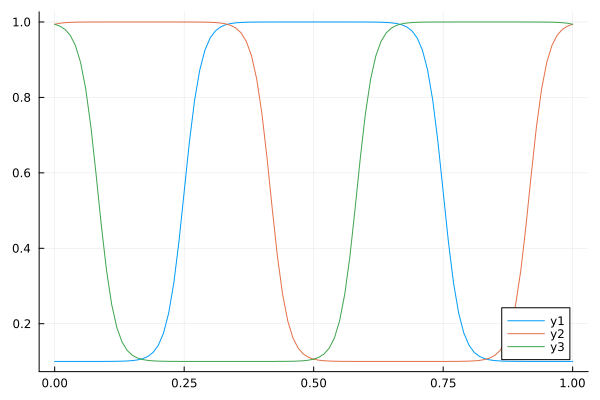

In [5]:
let T = 1, Δmax = 1, Δmin = 0.1, k = 30
    ts =  0:0.01:T
    deltas = stack([braiding_deltas(t, T, Δmax, Δmin, k) for t in ts])'
    plot(ts,deltas)
end

In [6]:
const γ01 = Matrix(1.0im * γ[0] * γ[1])
const γ02 = Matrix(1.0im * γ[0] * γ[2])
const γ03 = Matrix(1.0im * γ[0] * γ[3])

4×4 Matrix{ComplexF64}:
  0.0+0.0im   0.0+0.0im   0.0+0.0im  -1.0+0.0im
  0.0+0.0im   0.0+0.0im  -1.0+0.0im   0.0+0.0im
  0.0+0.0im  -1.0+0.0im   0.0+0.0im   0.0+0.0im
 -1.0+0.0im   0.0+0.0im   0.0+0.0im   0.0+0.0im

In [7]:
function H(t, (T, Δmin, Δmax, k))
    Δ1, Δ2, Δ3 = braiding_deltas(t, T, Δmax, Δmin, k)
    @. Δ1 * γ01 + Δ2 * γ02 + Δ3 * γ03
end
function H(t, (T, Δmin, Δmax, k), W)
    Δ1, Δ2, Δ3 = braiding_deltas(t, T, Δmax, Δmin, k)
    @. (W[1] + Δ1) * γ01 + (W[2] + Δ2) * γ02 + (W[3] + Δ3) * γ03
end

H (generic function with 2 methods)

In [8]:
function braid_heisenberg!(du, u, p, t, args...)
    ham = H(t, p, args...)
    heisenberg!(du, u, ham)
end
function heisenberg!(du, u, ham)
    mul!(du, ham, u, 1im, 0)
    mul!(du, u, ham, -1im, 1)
    # du .= 1im .* (ham * u .- u * ham)
    return du
end

heisenberg! (generic function with 1 method)

In [9]:
u0 = 1.0complex(Matrix(γ[1]))
T = 0.1
k = 100 / T
Δmax = 1e2 / T
Δmin = Δmax * 1e-2
σ = Δmax/10
p = (T, Δmin, Δmax, k)
tspan = (0.0, 2T)

prob = ODEProblem(braid_heisenberg!, u0, tspan, p)
W = OrnsteinUhlenbeckProcess(1/(T), 0.0, σ, 0.0, zeros(3), zeros(3))
rodeprob = RODEProblem(braid_heisenberg!, u0, tspan, p, noise=W, rand_prototype=zeros(Float64, 3), )
ts = range(0, tspan[2], 300)
deltas = stack([braiding_deltas(t, p...) for t in ts])'
plot(ts, deltas);

SciMLBase.TooManyArgumentsError: All methods for the model function `f` had too many arguments. For example,
an ODEProblem `f` must define either `f(u,p,t)` or `f(du,u,p,t)`. This error
can be thrown if you define an ODE model for example as `f(du,u,p1,p2,t)`.
For more information on the required number of arguments for the function
you were defining, consult the documentation for the `SciMLProblem` or
`SciMLFunction` type that was being constructed.

A common reason for this occurrence is due to following the MATLAB or SciPy
convention for parameter passing, i.e. to add each parameter as an argument.
In the SciML convention, if you wish to pass multiple parameters, use a
struct or other collection to hold the parameters. For example, here is the
parameterized Lorenz equation:

```julia
function lorenz(du,u,p,t)
  du[1] = p[1]*(u[2]-u[1])
  du[2] = u[1]*(p[2]-u[3]) - u[2]
  du[3] = u[1]*u[2] - p[3]*u[3]
 end
 u0 = [1.0;0.0;0.0]
 p = [10.0,28.0,8/3]
 tspan = (0.0,100.0)
 prob = ODEProblem(lorenz,u0,tspan,p)
```

Notice that `f` is defined with a single `p`, an array which matches the definition
of the `p` in the `ODEProblem`. Note that `p` can be any Julia struct.

Offending function: f
Methods:
# 1 method for generic function "braid_heisenberg!" from Main:
 [1] braid_heisenberg!(du, u, p, t, args...)
     @ c:\Users\vi2823sv\.julia\dev\QuantumDots\examples\braiding.ipynb:1


In [10]:
@time sol = solve(prob, saveat=ts)
@time rodesol = solve(rodeprob, saveat=ts, dt = T/100000, abstol=1e-3, reltol=1e-8)

UndefVarError: UndefVarError: `ts` not defined

In [11]:
projs = stack([[abs(tr(γ * sol(t))) for γ in (γ[1], γ[2], γ[3])] for t in ts])';
rodeprojs = stack([[abs(tr(γ * rodesol(t))) for γ in (γ[1], γ[2], γ[3])] for t in ts])';

UndefVarError: UndefVarError: `ts` not defined

In [12]:
plot(plot(ts ./ T, projs), plot(ts ./ T, rodeprojs))#, plot(ts ./ T, sdeprojs))#, plot(ts ./ T, sdeprojs2))

UndefVarError: UndefVarError: `ts` not defined

In [13]:
plot(map(norm, sol))
plot!(map(norm, rodesol))

UndefVarError: UndefVarError: `sol` not defined

In [14]:
plot(stack(rodesol.W.u)'[1:100:end,:])

UndefVarError: UndefVarError: `rodesol` not defined

In [15]:
plot(ts,stack(first.(sdesol.noise.(ts)))')

UndefVarError: UndefVarError: `ts` not defined

In [16]:
function prob_func(prob, i, repeat)
    #W = RealWienerProcess(0.0, zeros(3), zeros(3))
    W = OrnsteinUhlenbeckProcess(1/(T), 0.0, Δmax/5, 0.0, zeros(3), zeros(3))
    remake(prob; noise=W)
end
ensembleprob = EnsembleProblem(rodeprob;
    prob_func,
    #output_func=(sol, i) -> (map(s -> push!([abs(tr(γ * reshape(s, size(γ)))) for γ in (γ[1], γ[2], γ[3])], norm(s)), sol), false))
    output_func=(sol, i) -> ((map(s -> push!([abs(tr(γ * (s))) for γ in (γ[1], γ[2], γ[3])], norm(s)), sol)), false))

UndefVarError: UndefVarError: `rodeprob` not defined

In [17]:
enssol = solve(ensembleprob, EnsembleThreads(), #ImplicitEulerHeun(symplectic=true, theta=1 / 2, autodiff=false),
    trajectories=10, saveat=ts, abstol=1e-6, reltol=1e-8, dt = T/100000)

UndefVarError: UndefVarError: `ts` not defined

In [18]:
using DifferentialEquations.EnsembleAnalysis
mv = [timestep_meanvar(enssol, n) for n in 1:size(enssol, 1)];
v = stack(last.(mv))'
m = stack(first.(mv))'
plot(ts, m; ribbon = (sqrt.(v),sqrt.(v)))

UndefVarError: UndefVarError: `enssol` not defined